# Before the class

Set up a jupyter notebook on the Discovery HPC cluster following instructions here: https://services.dartmouth.edu/TDClient/1806/Portal/KB/ArticleDet?ID=124517.

Install pytorch on discovery

`pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu`

Download simulated data: sequences and their corresponding labels.

* sequences

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


In [2]:
len(sequences)

2000

* labels

In [3]:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

# Let's print the first few labels.
pd.DataFrame(labels, index=np.arange(1, len(labels)+1), 
             columns=['labels']).head()

,labels
1,0
2,0
3,0
4,1
5,1


In [4]:
# Count the number of 0s and 1s
print("Number of '0's: {}".format(labels.count('0')))
print("Number of '1's: {}".format(labels.count('1')))

Number of '0's: 1013
Number of '1's: 987


# Train a convolutional neural network to predict protein binding

The following tutorial is adapted from https://github.com/abidlabs/deep-learning-genomics-primer. 


See accompanying paper: Zou, J. et al. A primer on deep learning in genomics. Nat. Genet. 51, 12–18 (2019).
  


**Overview**: we will design a neural network that can discover binding motifs in DNA based on the results of an assay that determines whether a longer DNA sequence binds to the protein or not. Here, the longer DNA sequences are our independent variables (or predictors), while the positive or negative response of the assay is the dependent variable (or response).

![alternatvie text](https://camo.githubusercontent.com/66ca330dec8af29091cda75e89f32dfb29c67c99cd7eb76b57b54c3f685d58dc/68747470733a2f2f6769746875622e636f6d2f616269646c6162732f646565702d6c6561726e696e672d67656e6f6d6963732d7072696d65722f626c6f622f6d61737465722f53637265656e73686f7425323066726f6d253230323031382d30382d303125323032302d33312d30312e706e673f7261773d74727565)

**Data**: We will use simulated data that consists of DNA sequences of length 50 bases (chosen to be artificially short so that the data is easy to play around with), and is labeled with 0 or 1 depending on the result of the assay. Our goal is to build a classifier that can predict whether a particular sequence will bind to the protein and discover the short motif that is the binding site in the sequences that are bound to the protein.

## Data processing

We first need to transform our data to a format that can be used by the deep learning algorithm. 
* We use one hot encoding for DNA sequences. 

In [5]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [6]:
# One-hot encoding function for DNA sequences
def one_hot_encode_sequence(sequence):
    mapping = {'A': [1, 0, 0, 0],
               'C': [0, 1, 0, 0],
               'G': [0, 0, 1, 0],
               'T': [0, 0, 0, 1]}
    return np.array([mapping[base] for base in sequence])

# Encode all sequences
encoded_sequences = np.array([one_hot_encode_sequence(seq) for seq in sequences])

# Convert labels from strings to integers
encoded_labels = np.array([int(label) for label in labels])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Print to verify
print("One-hot encoded sequences (training):")
print(X_train_tensor)
print("Encoded binary labels (training):")
print(y_train_tensor)


One-hot encoded sequences (training):
tensor([[[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]],

        [[0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]],

        ...,

        [[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 0., 1., 0.],
    

## Model training

Model archtecture summary: 

Input: (batch_size, 100, 4)  # 100 bases, 4 channels (A, C, G, T)

→ Conv1D(4 → 32 filters, kernel_size=12)

→ MaxPool1D(kernel_size=4)

→ Flatten

→ Dense(16 units, ReLU)

→ Dense(2 units, Softmax)


In [7]:
# Define the 1D CNN model
class Conv1DModel(nn.Module):
    def __init__(self, input_length):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12)
        self.pool = nn.MaxPool1d(kernel_size=4)
        conv_output_length = input_length - 12 + 1
        pooled_length = conv_output_length // 4
        self.flattened_size = 32 * pooled_length
        self.fc1 = nn.Linear(self.flattened_size, 16)
        self.fc2 = nn.Linear(16, 2)
        
    def forward(self, x):
        x = x.permute(0, 2, 1) # (batch_size, channels, sequence_length)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

Epoch 1, Train Loss: 0.6800, Val Loss: 0.6467, Val Accuracy: 0.7775
Epoch 2, Train Loss: 0.5928, Val Loss: 0.5238, Val Accuracy: 0.8250
Epoch 3, Train Loss: 0.4766, Val Loss: 0.4487, Val Accuracy: 0.8800
Epoch 4, Train Loss: 0.4156, Val Loss: 0.4090, Val Accuracy: 0.9275
Epoch 5, Train Loss: 0.3873, Val Loss: 0.3750, Val Accuracy: 0.9650
Epoch 6, Train Loss: 0.3623, Val Loss: 0.3633, Val Accuracy: 0.9650
Epoch 7, Train Loss: 0.3505, Val Loss: 0.3549, Val Accuracy: 0.9725
Epoch 8, Train Loss: 0.3417, Val Loss: 0.3498, Val Accuracy: 0.9700
Epoch 9, Train Loss: 0.3352, Val Loss: 0.3500, Val Accuracy: 0.9800
Epoch 10, Train Loss: 0.3311, Val Loss: 0.3489, Val Accuracy: 0.9800
Epoch 11, Train Loss: 0.3286, Val Loss: 0.3441, Val Accuracy: 0.9825
Epoch 12, Train Loss: 0.3260, Val Loss: 0.3365, Val Accuracy: 0.9825
Epoch 13, Train Loss: 0.3233, Val Loss: 0.3387, Val Accuracy: 0.9775
Epoch 14, Train Loss: 0.3205, Val Loss: 0.3333, Val Accuracy: 0.9875
Epoch 15, Train Loss: 0.3192, Val Loss: 0.3

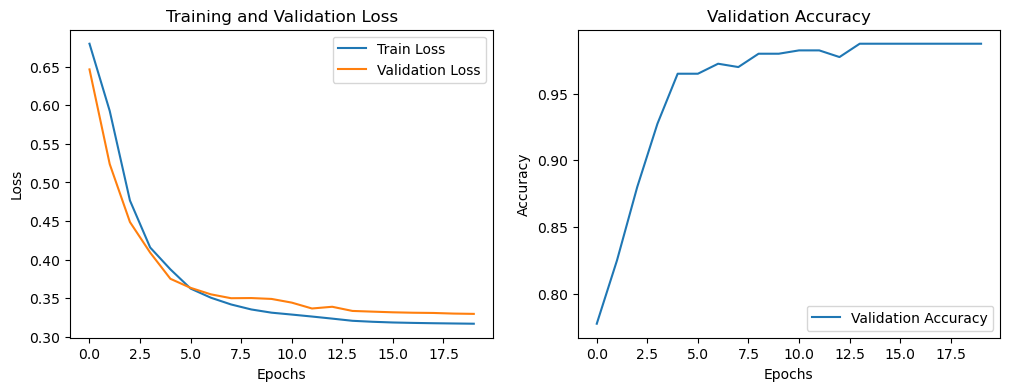

In [8]:
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt


# Create dataset and split into training and validation sets
dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_size = int(0.25 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialize model
model = Conv1DModel(input_length=X_train_tensor.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Initialize lists to store history
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(20):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_outputs = model(val_X)
            val_loss += criterion(val_outputs, val_y).item()
            pred = val_outputs.argmax(dim=1)
            correct += (pred == val_y).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / len(val_dataset))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

# Plotting the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.show()

## Prediction for new data

In [9]:
# predict for the first sequence in test set
model(X_test_tensor[0].unsqueeze(0))

tensor([[1.0086e-04, 9.9990e-01]], grad_fn=<SoftmaxBackward0>)

Predict for all sequences in test set and see how good it is.

Confusion matrix:
 [[  1 204]
 [195   0]]


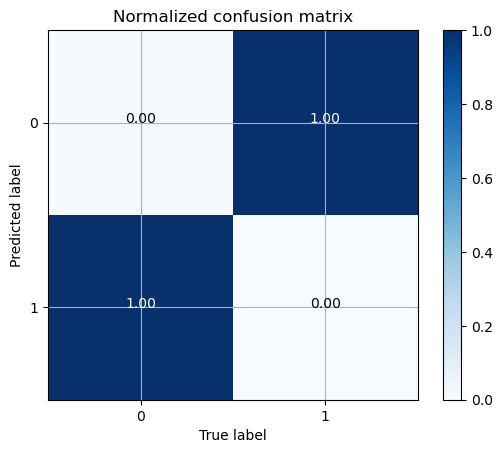

In [10]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model(X_test_tensor)
predicted_labels = predicted_labels[:,0].detach().numpy()
predicted_labels[predicted_labels> 0.5] = 1 
predicted_labels[predicted_labels<= 0.5] = 0 
cm = confusion_matrix(y_test_tensor.detach().numpy(), predicted_labels)
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')